In [1]:
from os import listdir
from os import path
from random import sample
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def loadDat(filename):
  fh = open(filename)
  dat = pd.read_csv(fh)
  fh.close()
  return dat

In [2]:
year = 2022
datadir = path.join('.', str(year))
files = listdir(datadir)
files

['proj_rb22.csv',
 'proj_wr22.csv',
 'proj_qb22.csv',
 'proj_te22.csv',
 'proj_k22.csv']

In [3]:
# need to exclude "current" data
files = [i for i in files if 'proj' in i]
patt = r'proj_(.*)' + str(year)[2:4] + '.csv'
pos = [re.sub(patt, r'\1', f) for f in files]
dat = {}
cols = set()
for p in pos:
  dat[p] = loadDat(path.join(datadir, files[pos.index(p)]))
  cols.update(set(dat[p].columns))
for p in pos:
  nr = len(dat[p].index)
  nodat = [0 for i in range(nr)]
  for i in cols.difference(set(dat[p].columns)):
    dat[p][i] = nodat
  dat[p] = dat[p][cols]
  dat[p]['pos'] = [p for i in range(nr)]
col1 = ['PlayerName','Team','pos','fpts']
colo = col1 + list(cols.difference(col1))
m = pd.concat(dat)[colo]
m['p_fg'] = m['fg'] * 4
m['p_xpt'] = m['xpt'] * 1
m['p_pass_yds'] = m['pass_yds'] / 25
m['p_pass_tds'] = m['pass_tds'] * 4
m['p_pass_ints'] = m['pass_ints'] * -2
m['p_rush_yds'] = m['rush_yds'] / 10
m['p_rush_tds'] = m['rush_tds'] * 6
m['p_fumbles'] = m['fumbles'] * -2
m['p_rec_yds'] = m['rec_yds'] / 20
m['p_rec_tds'] = m['rec_tds'] * 6
m['points'] = m.filter(regex = ("p_.*")).sum(axis = 1)
m = m.sort_values(by=['points'], ascending = False)
basePnt = {}
basePnt['k'] = m.loc[('k',12),'points']
basePnt['qb'] = m.loc[('qb',12),'points']
basePnt['rb'] = m.loc[('rb',24),'points']
basePnt['te'] = m.loc[('te',12),'points']
basePnt['wr'] = m.loc[('wr',36),'points']
m['marg'] = m['points'] - [basePnt[i] for i in m['pos']]
# alternative
#m.loc['qb','marg'] = (m.loc['qb','points'] - m.loc[('qb',12),'points']).values
d1 = m.loc[m['marg'] >= 0, ['PlayerName','pos','points','marg']]
d2 = d1.sort_values(by=['marg'], ascending = False)
d2['value'] = (12 * 200 - len(d2)) * d2['marg'] / sum(d2['marg']) + 1
d3 = d2.reset_index(drop = True)

In [4]:
d3.head()

,PlayerName,pos,points,marg,value
0,Jonathan Taylor,rb,274.730,130.575,115.477768
1,Derrick Henry,rb,254.220,110.065,97.496233
2,Josh Allen,qb,387.548,90.452,80.301115
3,Cooper Kupp,wr,155.880,80.065,71.194620
4,Deebo Samuel,wr,153.660,77.845,69.248301


In [5]:
d3.tail()

,PlayerName,pos,points,marg,value
102,Travis Etienne Jr.,rb,144.155,0.0,1.0
103,Rashod Bateman,wr,75.815,0.0,1.0
104,Robbie Gould,k,148.900,0.0,1.0
105,Russell Wilson,qb,297.096,0.0,1.0
106,Noah Fant,te,54.680,0.0,1.0


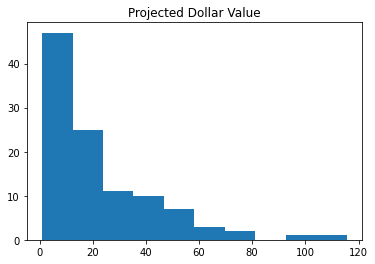

In [6]:
plt.hist(np.hstack(d3['value']))
plt.title('Projected Dollar Value')
plt.show()

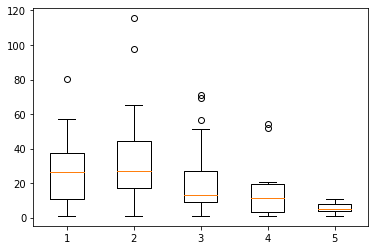

In [7]:
fig1, ax1 = plt.subplots()
data = [d3.loc[d3['pos'] == 'qb','value'], d3.loc[d3['pos'] == 'rb','value'], d3.loc[d3['pos'] == 'wr','value'], d3.loc[d3['pos'] == 'te','value'], d3.loc[d3['pos'] == 'k','value']]
ax1.boxplot(data)
plt.show()

In [8]:
# select rows by index
d3.iloc[range(0,3)]

,PlayerName,pos,points,marg,value
0,Jonathan Taylor,rb,274.730,130.575,115.477768
1,Derrick Henry,rb,254.220,110.065,97.496233
2,Josh Allen,qb,387.548,90.452,80.301115


In [9]:
# select rows by name
d3.loc[[10,20,40,80]]

,PlayerName,pos,points,marg,value
10,Travis Kelce,te,115.660,60.980,54.462411
20,Kyler Murray,qb,338.784,41.688,37.548721
40,Dalton Schultz,te,76.665,21.985,20.274698
80,Darnell Mooney,wr,83.085,7.270,7.373757


In [10]:
# select columns by index, and first 10 rows
d3.iloc[range(10),[0,4]]

,PlayerName,value
0,Jonathan Taylor,115.477768
1,Derrick Henry,97.496233
2,Josh Allen,80.301115
3,Cooper Kupp,71.194620
4,Deebo Samuel,69.248301
5,Austin Ekeler,65.193469
6,Christian McCaffrey,58.841629
7,Patrick Mahomes II,57.341561
8,Ja'Marr Chase,56.277222
9,Joe Mixon,56.036124


In [11]:
# select columns by name, and 5 random rows
d3.iloc[sample(range(len(d3)), 5), [d3.columns.get_loc(i) for i in ['pos','value']]]

,pos,value
48,wr,17.035216
26,wr,33.035364
84,wr,5.839497
23,qb,35.721635
69,wr,10.275702


In [12]:
# be careful when selecting a single column
# no longer a DataFrame
d3.iloc[range(5), d3.columns.get_loc('PlayerName')]

0    Jonathan Taylor
1      Derrick Henry
2         Josh Allen
3        Cooper Kupp
4       Deebo Samuel
Name: PlayerName, dtype: object

In [13]:
# maintain structure
pd.DataFrame(d3.iloc[range(5), d3.columns.get_loc('PlayerName')])

,PlayerName
0,Jonathan Taylor
1,Derrick Henry
2,Josh Allen
3,Cooper Kupp
4,Deebo Samuel


In [14]:
# select rows that satisfy condition
# every 10th row
d3.loc[[(i + 1) % 10 == 0 for i in range(len(d3))]]

,PlayerName,pos,points,marg,value
9,Joe Mixon,rb,206.930,62.775,56.036124
19,Lamar Jackson,qb,338.974,41.878,37.715298
29,Tee Higgins,wr,105.640,29.825,27.148186
39,Ezekiel Elliott,rb,166.200,22.045,20.327302
49,Elijah Mitchell,rb,162.410,18.255,17.004531
59,Josh Jacobs,rb,157.650,13.495,12.831342
69,Marquise Brown,wr,86.395,10.580,10.275702
79,Robert Woods,wr,83.100,7.285,7.386908
89,Allen Robinson II,wr,80.715,4.900,5.295930
99,Rodrigo Blankenship,k,150.800,1.900,2.665769


In [15]:
# quarterbacks
d3.loc[d3['pos'] == 'qb']

,PlayerName,pos,points,marg,value
2,Josh Allen,qb,387.548,90.452,80.301115
7,Patrick Mahomes II,qb,361.360,64.264,57.341561
16,Justin Herbert,qb,342.732,45.636,41.010013
19,Lamar Jackson,qb,338.974,41.878,37.715298
20,Kyler Murray,qb,338.784,41.688,37.548721
23,Jalen Hurts,qb,336.700,39.604,35.721635
33,Tom Brady,qb,326.034,28.938,26.370535
34,Dak Prescott,qb,325.174,28.078,25.616556
56,Joe Burrow,qb,311.170,14.074,13.338963
66,Aaron Rodgers,qb,308.128,11.032,10.671980


In [16]:
# wide receivers or tight ends, but only first 10
d3.loc[[i in ['wr','te'] for i in d3['pos']]].iloc[range(10)]

,PlayerName,pos,points,marg,value
3,Cooper Kupp,wr,155.880,80.065,71.194620
4,Deebo Samuel,wr,153.660,77.845,69.248301
8,Ja'Marr Chase,wr,138.865,63.050,56.277222
10,Travis Kelce,te,115.660,60.980,54.462411
12,Mark Andrews,te,112.835,58.155,51.985676
13,Justin Jefferson,wr,133.340,57.525,51.433342
17,Davante Adams,wr,120.310,44.495,40.009675
21,Mike Evans,wr,116.350,40.535,36.537862
22,Stefon Diggs,wr,115.445,39.630,35.744430
24,Tyreek Hill,wr,113.325,37.510,33.885783


In [17]:
# same thing, different way
d3.loc[[re.match(r'wr|te', i) is not None for i in d3['pos']]].iloc[range(10)]

,PlayerName,pos,points,marg,value
3,Cooper Kupp,wr,155.880,80.065,71.194620
4,Deebo Samuel,wr,153.660,77.845,69.248301
8,Ja'Marr Chase,wr,138.865,63.050,56.277222
10,Travis Kelce,te,115.660,60.980,54.462411
12,Mark Andrews,te,112.835,58.155,51.985676
13,Justin Jefferson,wr,133.340,57.525,51.433342
17,Davante Adams,wr,120.310,44.495,40.009675
21,Mike Evans,wr,116.350,40.535,36.537862
22,Stefon Diggs,wr,115.445,39.630,35.744430
24,Tyreek Hill,wr,113.325,37.510,33.885783


In [18]:
# values greater than 45
d3.loc[d3['value'] > 45]

,PlayerName,pos,points,marg,value
0,Jonathan Taylor,rb,274.730,130.575,115.477768
1,Derrick Henry,rb,254.220,110.065,97.496233
2,Josh Allen,qb,387.548,90.452,80.301115
3,Cooper Kupp,wr,155.880,80.065,71.194620
4,Deebo Samuel,wr,153.660,77.845,69.248301
5,Austin Ekeler,rb,217.375,73.220,65.193469
6,Christian McCaffrey,rb,210.130,65.975,58.841629
7,Patrick Mahomes II,qb,361.360,64.264,57.341561
8,Ja'Marr Chase,wr,138.865,63.050,56.277222
9,Joe Mixon,rb,206.930,62.775,56.036124


In [19]:
# combining conditions with AND
# running backs with value between 10 and 15
d3.loc[(d3['pos'] == 'rb') & (d3['value'] >= 20) & (d3['value'] <= 25)]

,PlayerName,pos,points,marg,value
36,David Montgomery,rb,168.91,24.755,22.703214
39,Ezekiel Elliott,rb,166.20,22.045,20.327302
41,D'Andre Swift,rb,166.02,21.865,20.169492


In [20]:
# combining conditions with OR
# rounded value ends in '9' or value is 1
d3.loc[(round(d3['value']) % 10 == 9) | (d3['value'] == 1)]

,PlayerName,pos,points,marg,value
4,Deebo Samuel,wr,153.660,77.845,69.248301
6,Christian McCaffrey,rb,210.130,65.975,58.841629
18,Nick Chubb,rb,188.010,43.855,39.448574
44,Darren Waller,te,75.370,20.690,19.139345
45,George Kittle,te,74.945,20.265,18.766739
74,JuJu Smith-Schuster,wr,85.450,9.635,9.447201
75,Jerry Jeudy,wr,85.225,9.410,9.249939
76,Matt Gay,k,158.100,9.200,9.065828
102,Travis Etienne Jr.,rb,144.155,0.000,1.000000
103,Rashod Bateman,wr,75.815,0.000,1.000000


In [21]:
# combining conditions with complicated combinations
# kickers with value > 6 or tight end with value < 5
d3.loc[((d3['pos'] == 'k') & (d3['value'] > 6)) | ((d3['pos'] == 'te') & (d3['value'] < 5))]

,PlayerName,pos,points,marg,value
67,Daniel Carlson,k,159.900,11.000,10.643925
68,Justin Tucker,k,159.500,10.600,10.293236
76,Matt Gay,k,158.100,9.200,9.065828
78,Harrison Butker,k,157.000,8.100,8.101435
81,Greg Joseph,k,156.100,7.200,7.312387
94,Mike Gesicki,te,57.355,2.675,3.345227
95,Tyler Higbee,te,57.170,2.490,3.183034
98,Pat Freiermuth,te,56.790,2.110,2.849880
100,David Njoku,te,55.215,0.535,1.469045
106,Noah Fant,te,54.680,0.000,1.000000


In [22]:
# select columns that match pattern
m.filter(regex = ("p_.*")).iloc[range(10)]

p_fg  p_xpt  p_pass_yds  p_pass_tds  p_pass_ints  p_rush_yds  \
qb 0    0.0    0.0     176.328       138.4        -27.8       66.22   
   1    0.0    0.0     193.760       143.6        -23.2       36.00   
   2    0.0    0.0     187.372       135.6        -26.6       29.96   
   3    0.0    0.0     149.344        98.0        -26.4       95.63   
   4    0.0    0.0     170.524       109.2        -24.6       55.26   
   5    0.0    0.0     145.820        97.6        -25.6       77.28   
   6    0.0    0.0     193.844       146.0        -23.8        4.59   
   7    0.0    0.0     182.864       133.6        -23.4       22.91   
   8    0.0    0.0     183.240       125.2        -25.6       18.73   
   11   0.0    0.0     170.708       130.4        -14.2       13.62   

       p_rush_tds  p_fumbles  p_rec_yds  p_rec_tds  
qb 0         41.4       -7.0        0.0        0.0  
   1         16.8       -5.6        0.0        0.0  
   2         19.2       -2.8        0.0        0.0  
   3         29.4       -7.0        0.0        0.0  
   4         33.0       -4.6        0.0        0.0  
   5         47.4       -5.8        0.0        0.0  
   6         10.2       -4.8        0.0        0.0  
   7         17.4       -8.2        0.0        0.0  
   8         13.2       -3.6        0.0        0.0  
   11        10.8       -3.2        0.0        0.0

In [23]:
# select empty DataFrame
d3.loc[[False] * len(d3)]

,PlayerName,pos,points,marg,value


<!--
quarto render ffv_py.qmd
-->